# DIGHUM 101: Practicing the Digital Humanities

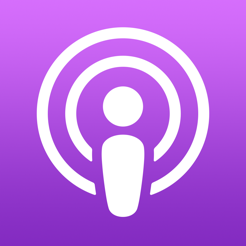

# Introduction
Podcasts have increasingly become a popular form of media over the past two decades. Since being created by Adam Curry and Dave Winer in 2004, the podcast industry has grown in size and diversity of categories. According to an article by Jay Baer, in 2019, more than half of the U.S. population had listened to a podcast, and 32% of Americans were monthly listeners. Many individuals listen to podcasts for entertainment while others listen for educational purposes.

Over the past few months, the media has been overwhelmed with many different issues and current events. Because podcasts are an influential form of media, it is likely that there were shifts in listening patterns that correlate with other shifts in social media due to the outbreak of COVID-19 and the Black Lives Matter movement.

<table><tr>
<td> 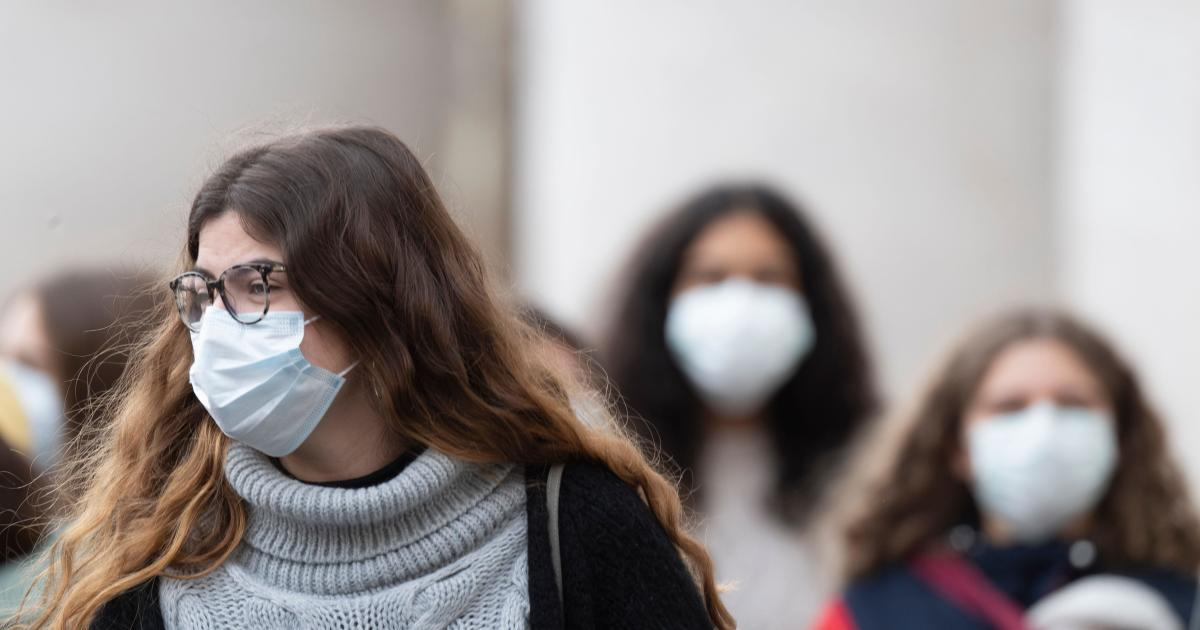 </td>
<td> 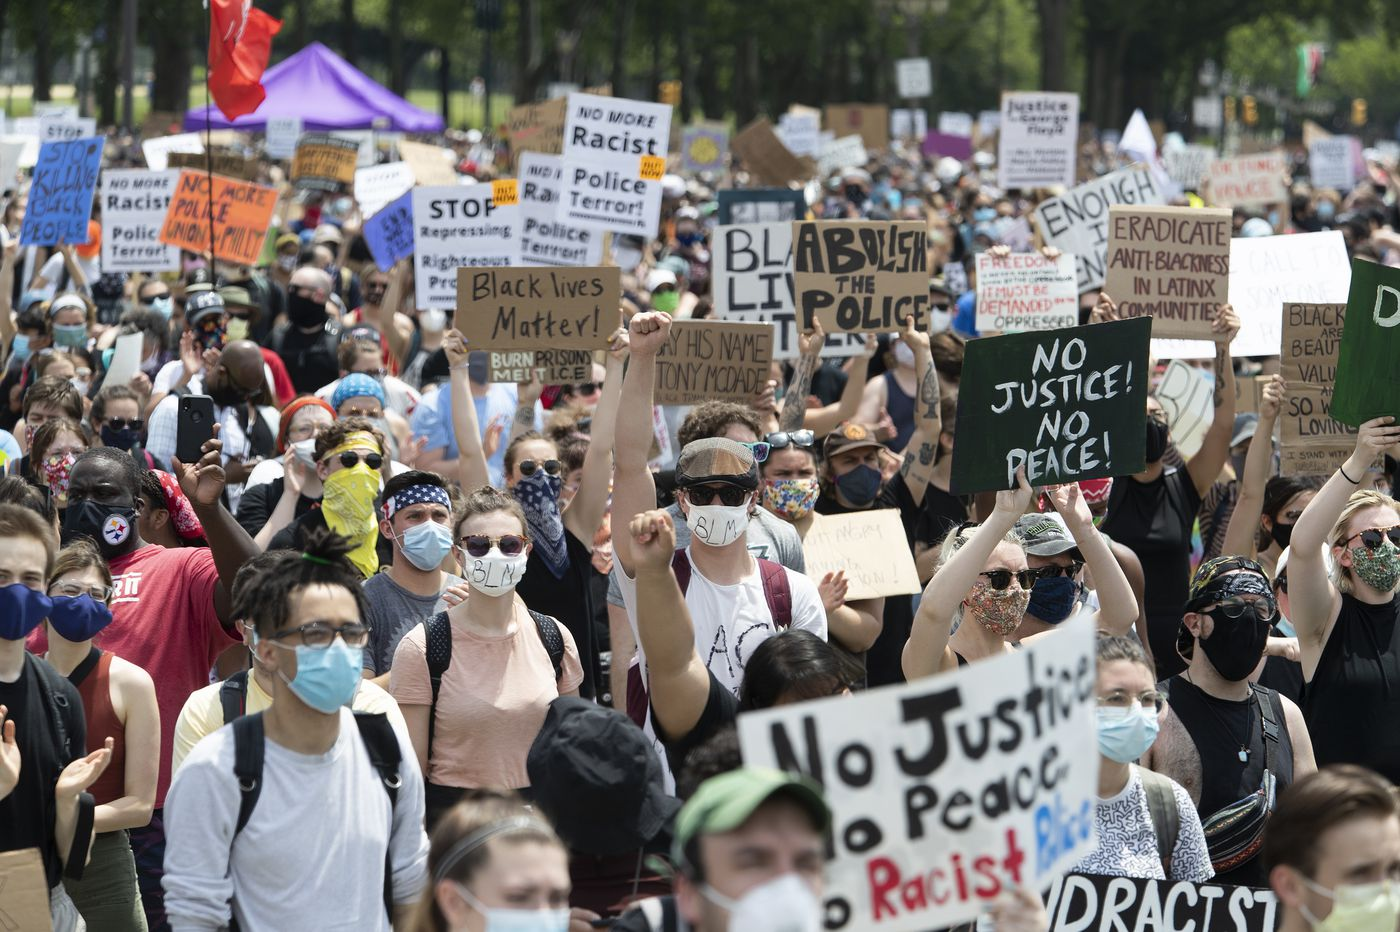 </td>
</tr></table>

# Research Questions
1. Does the popularity of podcasts directly reflect what’s happening in the world?
2. How have the most popular episodes changed in topic over the past few months?

These questions consider how media outlets—specifically podcasts—influence people and the information that is consumed. Through these questions, I am trying to understand how people have dealt with informing themselves during this time of uncertainty.

# Dataset
I collected my data of podcast top charts from [iTunes Charts](www.itunescharts.net). I wanted to find the top rating episode per day, but was only able to find the top rating podcast show for each day. For each month up to June, I specified which episodes most likely contributed to the podcast being ranked first in the U.S. This may not have been an accurate procedure, but I included the episodes that were released on the days leading up to when the podcast ranked first. Each month does not have the same number of top episodes because more shows were ranked first in some months.

After documenting the top episodes for each month, I downloaded the transcripts of the episodes from [Podgist](www.podgist.com), [Podscribe](www.podscribe.com), and podcast shows' websites. I was unable to find transcripts for some episodes, and although I was able to transcribe one episode myself, I did not have sufficient time to transcribe all of the missing episodes for this project.

# Install and Import

In [52]:
from collections import Counter # count most common words
import gensim # word2vec model
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
import numpy as np
import os
import pandas as pd
import pyLDAvis.sklearn #nvisualize our topic models
import re # regular expressions
import seaborn as sns
# CV (multiple train/test splitting)
from sklearn.model_selection import cross_val_score, train_test_split
# Algorithms (unsupervised)
from sklearn.decomposition import LatentDirichletAllocation, PCA
# (supervised)
from sklearn.linear_model import LogisticRegression
# tools to create our own DTMs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# speed up your machine learning setup
from sklearn.pipeline import Pipeline
# mix up our 
from sklearn.utils import shuffle

import spacy
# visualize word clouds
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Compiling data and preprocessing to produce word cloud

In [277]:
stop_words = stopwords.words("english")
new_words = ['yeah','hi','ha','one','thing','want','tell','lot', '::', '▶','like', 'would', 'think', 'us', 'get', "i'm",'way','see',
             "he’s"," that’s", 'go', 'got','guy', 'really','look','going','gonna','know','people','said','say','let','guy','mean','two',
            "that's", "there's","he's","we're",'good','things','could','also','guys','shit','fuck','fuckin','fucking','ok',"can't"
            'oh','—','gotta','actually','something','happen',"they're","i've",'put','archived','recording','much','many']
stop_words.extend(new_words)

def create_wordcloud_data(dir_name, base="../../Desktop/podcasts2020/"):
    path = base + dir_name
    listdir = os.listdir(path)
    # Designate an empty dictionary to store the filename and text as columns
    for_dataframe = {}

    # Loop through the directory of text files and open and read them
    for file in listdir:
        if file == ".DS_Store": continue
        with open(path + "/" + file, "r", encoding="utf-8") as to_open:
             for_dataframe[file] = to_open.read()

    # Create and append the dataframe with two columns - the file name and the text itself
    podcasts = (pd.DataFrame.from_dict(for_dataframe, orient = "index")
                    .reset_index().rename(index = str, 
                                          columns = {"index": "File", 0: "Text"}))


##PREPROCESSING
    # Remove punctuation
    podcasts["Text_processed"] = podcasts["Text"].map(lambda x: re.sub('[,\.!?]', '', x))

    # Convert to lowercase
    podcasts["Text_processed"] = podcasts["Text_processed"].map(lambda x: x.lower())

    # Remove digits
    podcasts['Text_processed'] = podcasts['Text_processed'].str.replace('\d+', '')

    # Punctuation and digits are gone! ... ?
    list(podcasts[0:1]["Text_processed"])



    # Save the "Text_processed" column as one long string
    long_string = ','.join(list(podcasts["Text_processed"].values))
#     long_string

    # Tokenize long_string
    pod_tokens = long_string.split()

    # Remove stopwords
#     stop = stopwords.words("english")
#     no_stops = [word for word in pod_tokens if word not in stopwords.words('english')]
    no_stops = [word for word in pod_tokens if word not in stop_words]
    freq_pod = Counter(no_stops)

    # Print the 20 most common words
    pod_df = pd.DataFrame(freq_pod.most_common(20), columns = ["Word", "Frequency"])
    #pod_df


    # Define an empty bag (of words)
    vectorizer = CountVectorizer()

    # Use the .fit method to tokenize the text and learn the vocabulary
    vectorizer.fit(podcasts["Text_processed"])

    # Print the vocabulary
    #vectorizer.vocabulary_


    # Encode the documents
    vector = vectorizer.transform(podcasts["Text_processed"])
    #print(vector) 
    #
    #
    #print(vector.shape)
    #print(type(vector))


    # View as a multidimensional array before converting to data frame
    # Rows are the documents
    # Columns are the terms
    #print(vector.toarray())


    # What other processing steps could you include here
    # ... instead of doing them manually above? 
    bigram_vectorizer = CountVectorizer(ngram_range = (1,2),
                                        stop_words = "english",
                                        token_pattern = r'\b\w+\b', 
                                        min_df = 1)
    #bigram_vectorizer


    # Analyze long_string in the bigram bag of words
    analyze = bigram_vectorizer.build_analyzer()
    vocab = analyze(long_string)

    # Show the 20 most commons
    freq = Counter(vocab)
    stop_df = pd.DataFrame(freq.most_common(20), columns = ["Word", "Frequency"])
    

    
#     return long_string, stop_df
    no_stops_string = " ".join(no_stops)
    return no_stops_string, pod_df


# Fit the topic model

In [278]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

def create_topic_model(pod_tokens, n_topics = 5):
    
    # TfidfVectorizer to create the DTM
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.90,
                                       max_features = 5000,
                                       stop_words = "english")
    # Fit
    tfidf = tfidf_vectorizer.fit_transform(pod_tokens)

    # Instantiate our LDA model
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                    max_iter = 20, 
                                    random_state = 5)
    lda = lda.fit(tfidf)
    
    # Return the topics
    tf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, 20)
    
    panel = pyLDAvis.sklearn.prepare(lda_model = lda, 
                                 dtm = tfidf, 
                                 vectorizer = tfidf_vectorizer, 
                                 mds = "tsne")
#     pyLDAvis.display(panel)
#     pyLDAvis.show(panel)
    return panel

# Producing visuals for each month

## Word Clouds

### Jan 2020 Word Cloud

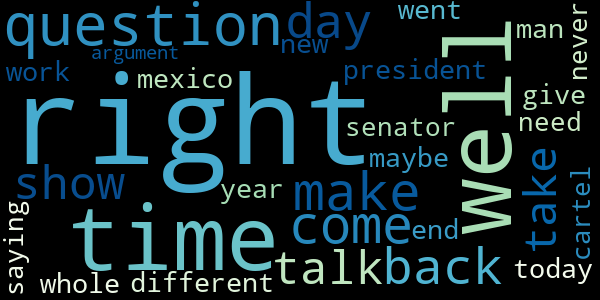

In [279]:
dir_name = "podcast jan2020"
long_string, stop_df = create_wordcloud_data(dir_name)
pod_tokens1 = long_string.split()

# Define a word cloud variable
cloud = WordCloud(background_color = "black", 
                  max_words = 30, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5,
                 colormap = 'GnBu')

# Process the word cloud
cloud.generate(long_string)
cloud.to_image()

### Feb 2020 Word Cloud

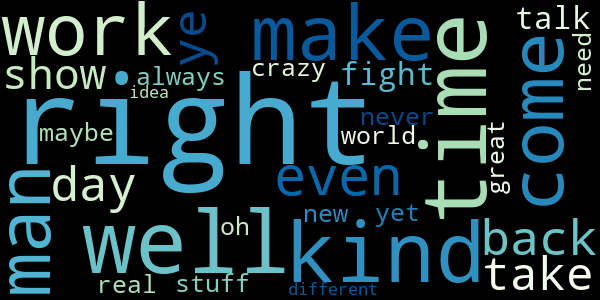

In [280]:
path2 = "podcast feb2020"
long_string2, stop_df2 = create_wordcloud_data(path2)
pod_tokens2 =  long_string2.split()

# Define a word cloud variable
cloud = WordCloud(background_color = "black", 
                  max_words = 30, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5,
                 colormap = 'GnBu')

# Process the word cloud
cloud.generate(long_string2)
cloud.to_image()

### Mar 2020 Word Cloud

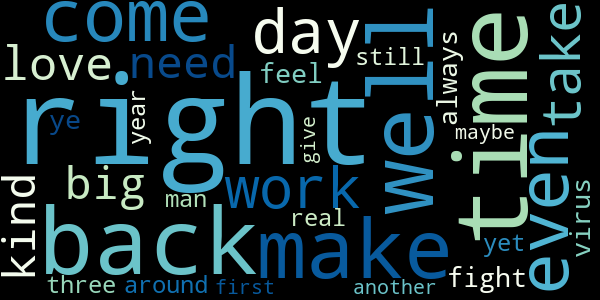

In [281]:
path3 = "podcast mar2020"
long_string3, stop_df3 = create_wordcloud_data(path3)
pod_tokens3 =  long_string3.split()

# Define a word cloud variable
cloud = WordCloud(background_color = "black", 
                  max_words = 30, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5,
                 colormap = 'GnBu')

# Process the word cloud
cloud.generate(long_string3)
cloud.to_image()

### Apr 2020 Word Cloud

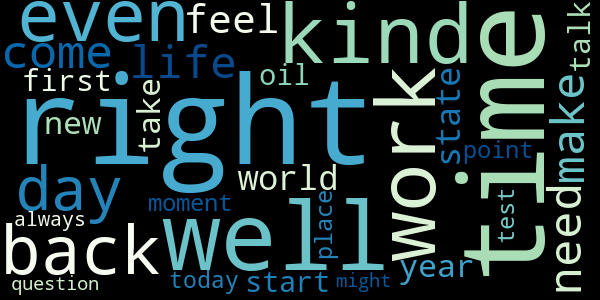

In [282]:
path4 = "podcast apr2020"
long_string4, stop_df4 = create_wordcloud_data(path4)
pod_tokens4 =  long_string4.split()

# Define a word cloud variable
cloud = WordCloud(background_color = "black", 
                  max_words = 30, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5,
                 colormap = 'GnBu')

# Process the word cloud
cloud.generate(long_string4)
cloud.to_image()

### May 2020 Word Cloud

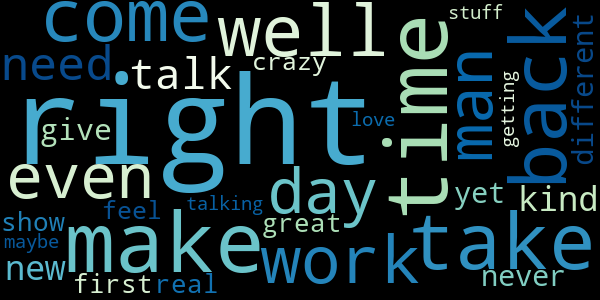

In [283]:
path5 = "podcast may2020"
long_string5, stop_df5 = create_wordcloud_data(path5)
pod_tokens5 =  long_string5.split()

# Define a word cloud variable
cloud = WordCloud(background_color = "black", 
                  max_words = 30, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5,
                 colormap = 'GnBu')

# Process the word cloud
cloud.generate(long_string5)
cloud.to_image()

### Jun 2020 Word Cloud

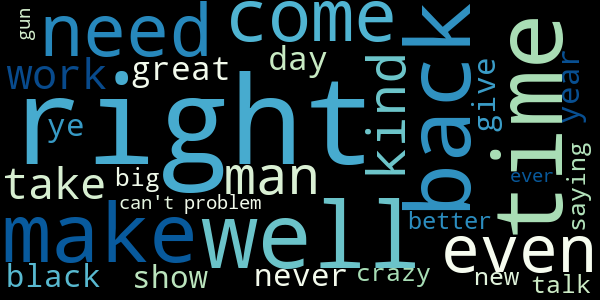

In [284]:
path6 = "podcast jun2020"
long_string6, stop_df6 = create_wordcloud_data(path6)
pod_tokens6 =  long_string6.split()

# Define a word cloud variable
cloud = WordCloud(background_color = "black", 
                  stopwords = 'archived recording',
                  max_words = 30, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5,
                 colormap = 'GnBu')

# Process the word cloud
cloud.generate(long_string6)
cloud.to_image()

# Bar plots

### Jan 2020 Bar Plot

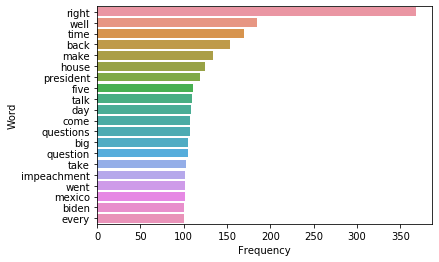

In [285]:
pod_barplot = sns.barplot(x = "Frequency", 
                         y = "Word", 
                         data = stop_df, 
                         orient = "h")

### Feb 2020 Bar Plot

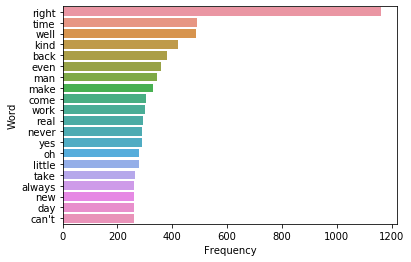

In [286]:
pod_barplot = sns.barplot(x = "Frequency", 
                         y = "Word", 
                         data = stop_df2, 
                         orient = "h")

### Mar 2020 Bar Plot

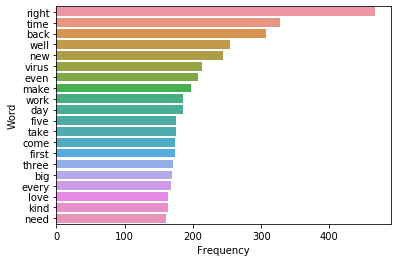

In [287]:
pod_barplot = sns.barplot(x = "Frequency", 
                         y = "Word", 
                         data = stop_df3, 
                         orient = "h")

### Apr 2020 Bar Plot

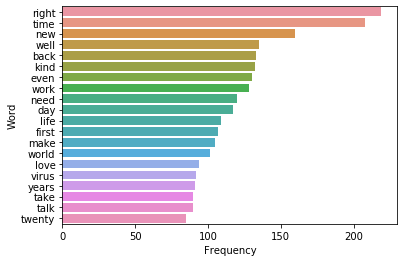

In [288]:
pod_barplot = sns.barplot(x = "Frequency", 
                         y = "Word", 
                         data = stop_df4, 
                         orient = "h")

### May 2020 Bar Plot

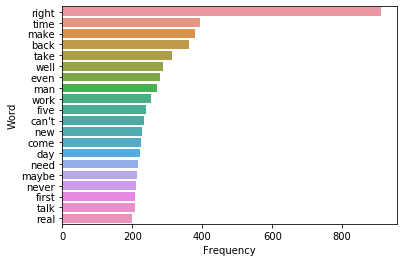

In [289]:
pod_barplot = sns.barplot(x = "Frequency", 
                         y = "Word", 
                         data = stop_df5, 
                         orient = "h")

### Jun 2020 Bar Plot

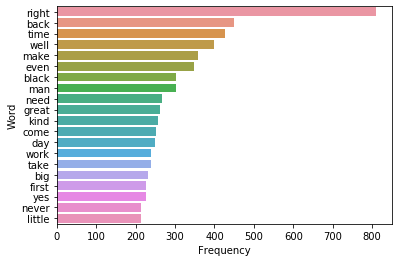

In [290]:
pod_barplot = sns.barplot(x = "Frequency", 
                         y = "Word", 
                         data = stop_df6, 
                         orient = "h")

## Topic Models

### Jan 2020 Topic Model

In [268]:
panel1 = create_topic_model(pod_tokens1)
pyLDAvis.display(panel1)


Topic #0:
make big man new democrats pretty evidence love point years probably let saw long heard try matter case senator sort

Topic #1:
president house ll talk mexico joe trying john kind getting senate video great times bit country cartel vote listen comes

Topic #2:
time questions maybe different saying need fight everybody trial use asked thought pro ass tat says better set family knows

Topic #3:
right day went biden end world talking life trump year witnesses stuff best quo mexican started government bunch interesting wanted

Topic #4:
question come impeachment little today work real yes crazy senators sure believe money came corruption start called quid answer used


### Feb 2020 Topic Model

In [269]:
panel2 = create_topic_model(pod_tokens2)
pyLDAvis.display(panel2)


Topic #0:
real love use talking ass end goes believe open black place pretty wrong course em ideas china twitter girl change

Topic #1:
right make work fight stuff big need bad getting problem free thousand dont god live sort tat called com start

Topic #2:
come yes little ll day world maybe life try weird sure space best everybody trying used remember came exactly makes

Topic #3:
man oh new great talk years feel better year probably hard person percent went away point watch funny started fact

Topic #4:
time kind different crazy saying money old long thought idea bit happened friends slash video nice able let hey play


### Mar 2020 Topic Model

In [270]:
panel3 = create_topic_model(pod_tokens3)
pyLDAvis.display(panel3)


Topic #0:
right big man talk oh thousand crazy biden went pretty best china place believe saw couple food away health understand

Topic #1:
new little real times years thought trying great came bad try daily point sure corona tat com dot idea used

Topic #2:
time day ll come kind yes life maybe long percent end use money today started stuff night old better weeks

Topic #3:
fight feel game president year book thank start days getting different states hard joe everybody able question city kids took

Topic #4:
virus make work love need world ass talking home york thirty happened called saying seen sort story free let house


### Apr 2020 Topic Model

In [271]:
panel4 = create_topic_model(pod_tokens4)
pyLDAvis.display(panel4)


Topic #0:
kind need talk thank times country big place long working daily case thousand best maybe family understand looking read course

Topic #1:
day virus states start little hard yes question york trying loneliness far test sense let number social clear government nineteen

Topic #2:
time new life make feel different ll says story testing hear tests free biden person ways seeger year getting star

Topic #3:
work love years come health com state public important away sure came book oh city small protests saw fact old

Topic #4:
right world oil president home today point help moment started thirty thought china saying talking dot pandemic real comes able


### May 2020 Topic Model

In [272]:
panel5 = create_topic_model(pod_tokens5)
pyLDAvis.display(panel5)


Topic #0:
need getting point stuff bad everybody trying long basically best tat business hard believe makes able sense friends saw blue

Topic #1:
new talk different oh talking world fight used body idea virus listen cause away place watch important old com movie

Topic #2:
make man work day maybe ll real kind money great yes little saying year use came sure ass problem dont

Topic #3:
right time big crazy better vitamin feel years gets thought person thousand kids comes sort guess seen looking making certain

Topic #4:
come percent love life went free start try deal wrong goes home studies god hear called health twitter says ago


### Jun 2020 Topic Model

In [273]:
panel6 = create_topic_model(pod_tokens6)
pyLDAvis.display(panel6)


Topic #0:
man great problem love away went world hard fact understand god basically run remember american comes took com sure thousand

Topic #1:
right archived new better music police white point old place started idea probably story night times home video cause house

Topic #2:
time need recording big maybe money feel end car came person job use trying getting best dont stuff talking happened

Topic #3:
make black kind day work little bad crazy saying ll talk year percent saw fight cops wanted let head face

Topic #4:
come yes years oh real life different june long country thought ass gun start morris provost used live looking weird


# Limitations
- I used my own judgement in selecting specific episodes that contributed to the show being first on the top charts; a completely different set of episodes could have caused the show to be ranked #1.
- I was unable to find the transcripts for all the podcasts, which removed a portion of podcasts that were mostly about true crime.
- I do not have all the data for June yet, meaning the analysis is not representative of the entire month.

# Conclusion
The LDA visualizations were the most relevant to understanding how podcast content has reflected current events. The progression of current events is evident in the produced topics: January mostly consists of politics regarding Trump's impeachment while June's topics are based Black Lives Matter protests and police brutality.

For the most part, popular podcast episodes did represent the major current events. An interesting point I found from the data collection process was that older podcasts were resurfacing in relation to current events. The podcast '1619' was released in 2019, but reached the #1 spot for several days in June. This supports the claim that podcast popularity is not only based on recent releases.

I hope to improve this project by providing context of current events with news headlines. As of now, I have identified that conversations of COVID-19 become prevalent beginning in March, but this only confirms my previous knowledge. Based on these topic models, there is no large scale discussion about the economy; this could be a result of me not knowing as much about the economy or it may be indicating that the popular podcasts are not related to economic issues. I will need to include and compare data about other forms of media.